In [39]:
from cProfile import label

# class that inherits from property based test
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import scipy
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylabel
from numpy.f2py.cb_rules import cb_map
from qiskit import QuantumCircuit
from sympy.printing.pretty.pretty_symbology import line_width

from qucheck.property import Property
from qucheck.input_generators import RandomState
from qucheck.test_runner import TestRunner

In [40]:
def read_merged_data_to_dataframe(algorithm_name):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{algorithm_name}_merged_results.csv"
    return pd.read_csv(filename)

In [41]:
qt_df = read_merged_data_to_dataframe("quantum_teleportation")
dj_df = read_merged_data_to_dataframe("deutsch_jozsa")
qft_df = read_merged_data_to_dataframe("quantum_fourier_transform")
qpe_df = read_merged_data_to_dataframe("quantum_phase_estimation")
grover_df = read_merged_data_to_dataframe("grovers_algorithm")

all_df = [qt_df, dj_df, qft_df, qpe_df, grover_df]
all_df = pd.concat(all_df)

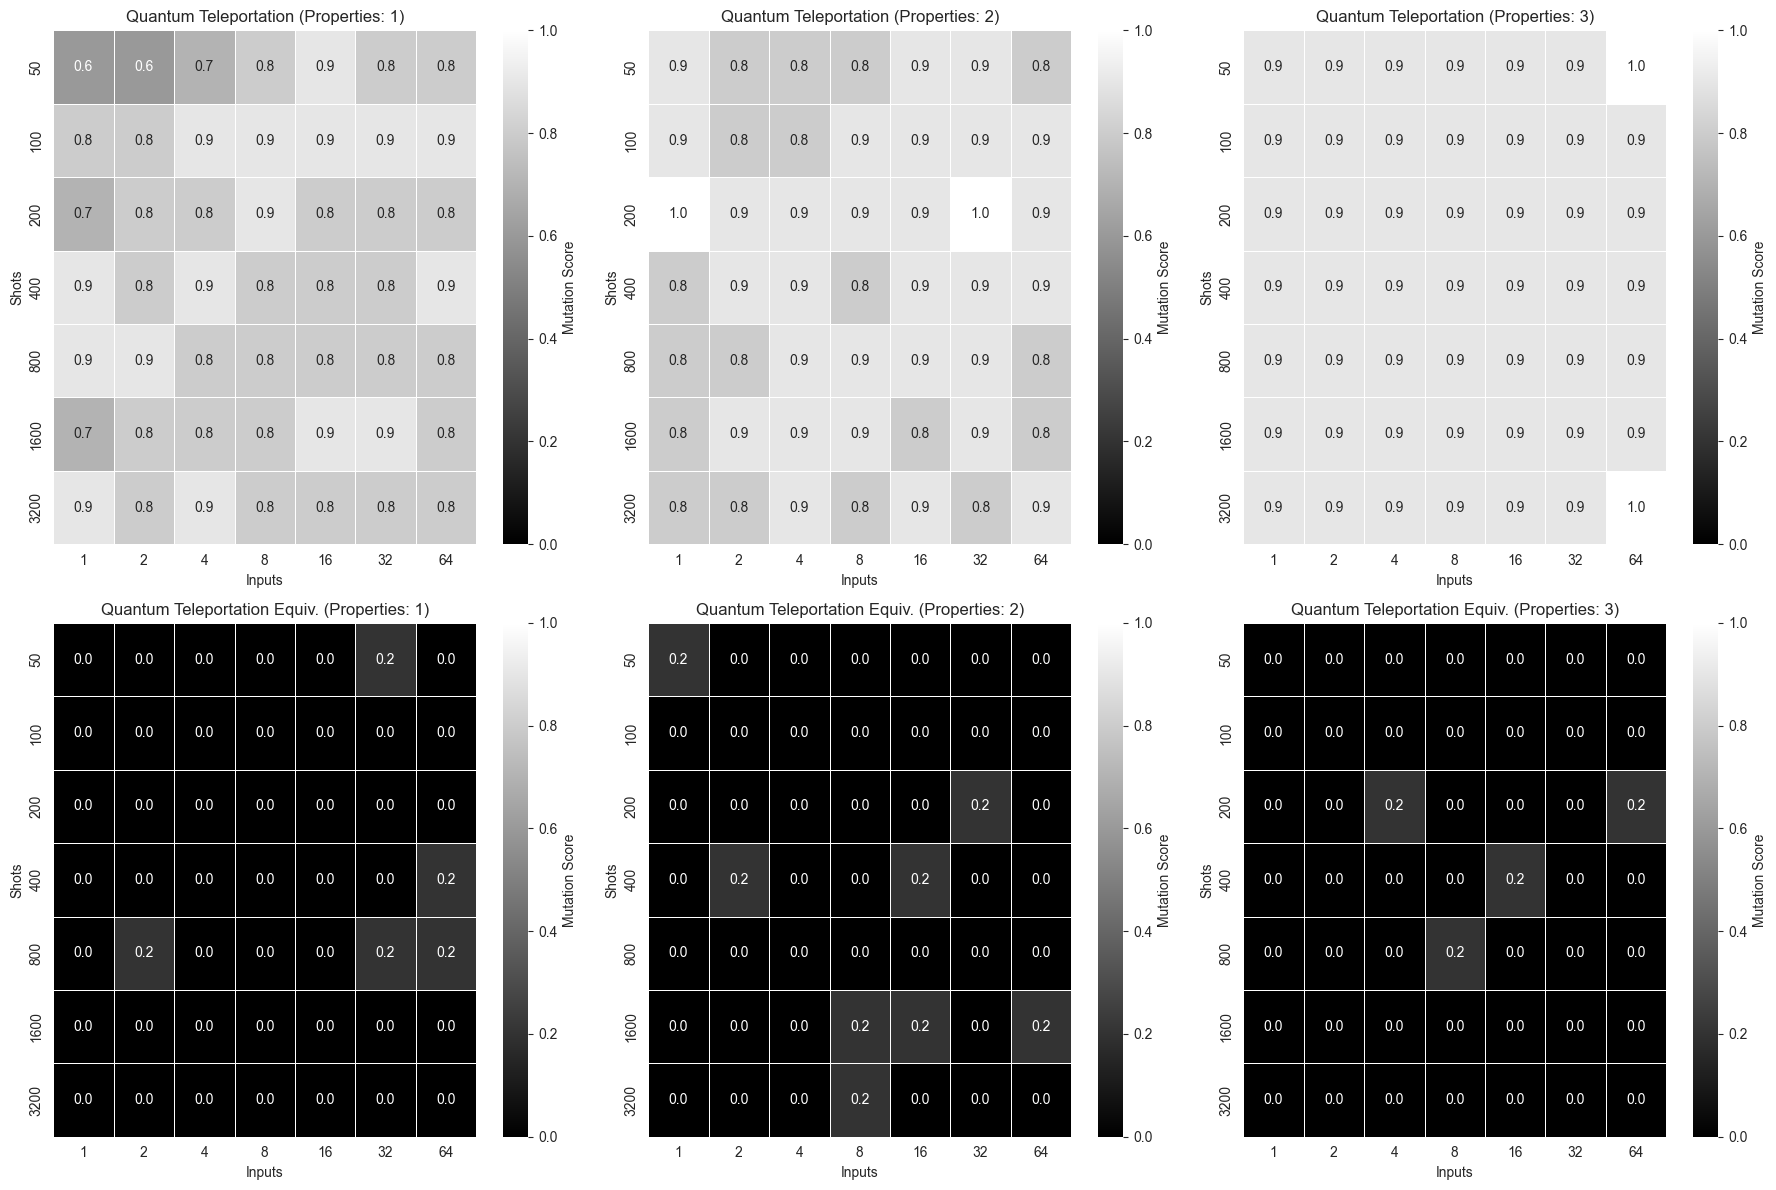

In [61]:
def plot_failures(df, algorithm_name, dp_format=".1f"):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # viridis or magma
    palette = sns.color_palette("gray", as_cmap=True)

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
                
        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]
        
        failure_rate = failure_rate / max_value

        sns.heatmap(failure_rate, annot=True, cmap=palette, ax=axes[0, i], fmt=dp_format, 
                    linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
        
        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]
        
        pass_rate = pass_rate / max_value
        
        sns.heatmap(pass_rate, annot=True, cmap=palette, ax=axes[1, i], fmt=dp_format, 
                    linewidth=0.5, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')

    plt.tight_layout()
    plt.savefig(f"{algorithm_name.replace(' ', '_')}_failures_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_failures(qt_df, "Quantum Teleportation")

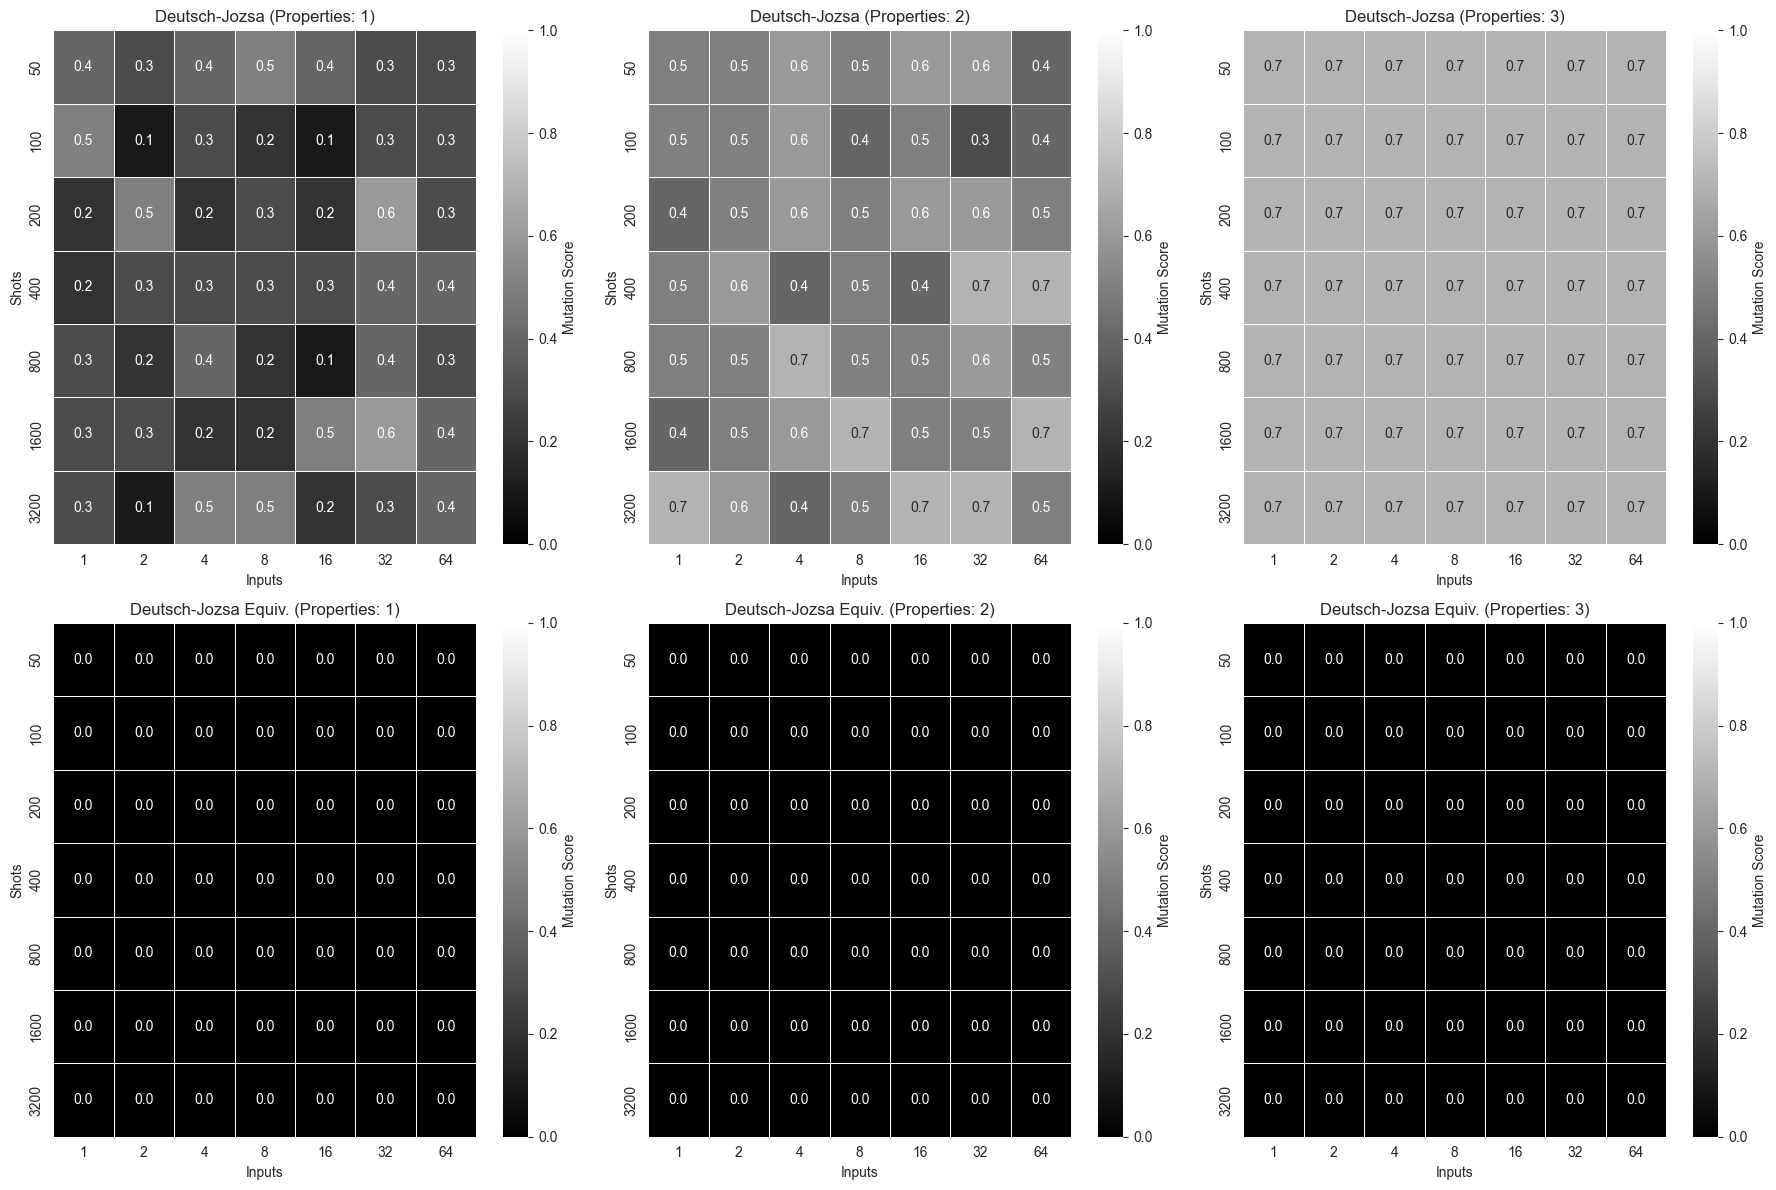

In [62]:
plot_failures(dj_df, "Deutsch-Jozsa")

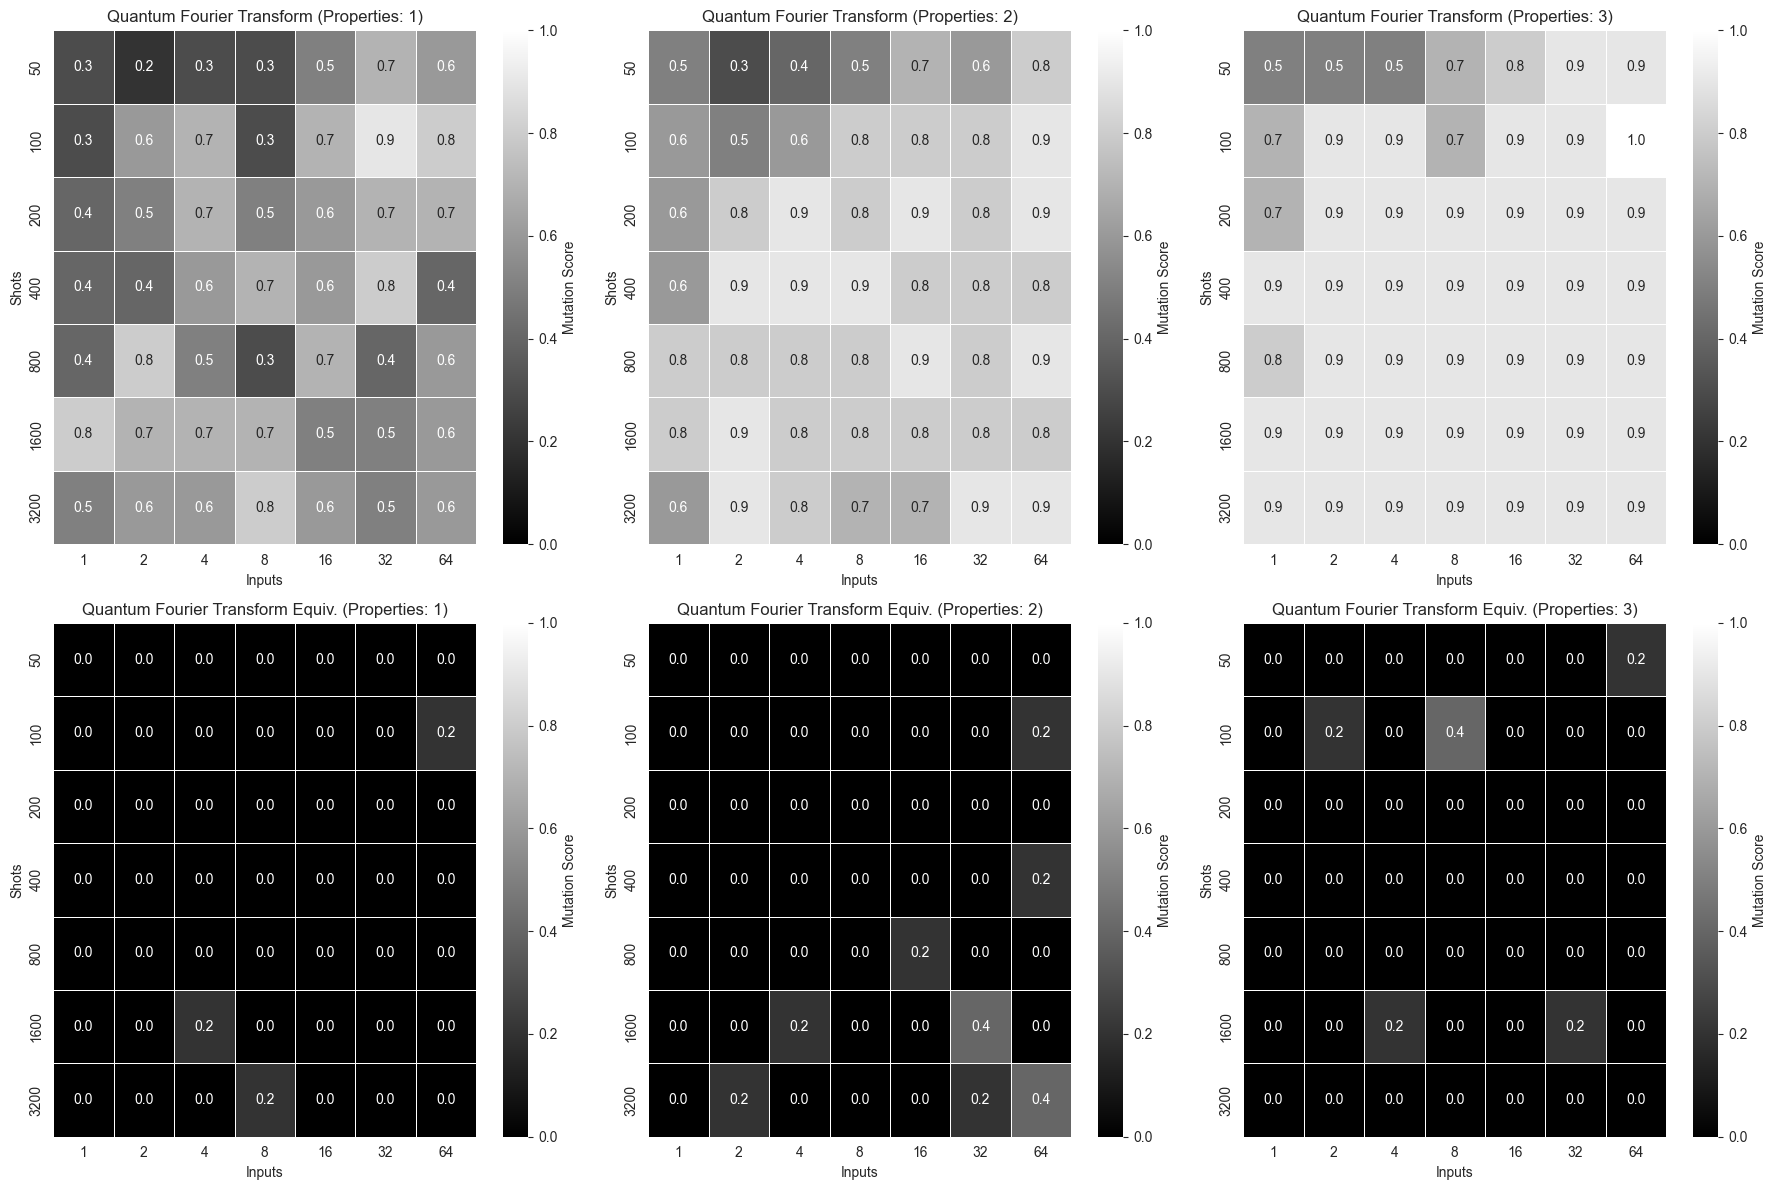

In [63]:
plot_failures(qft_df, "Quantum Fourier Transform")

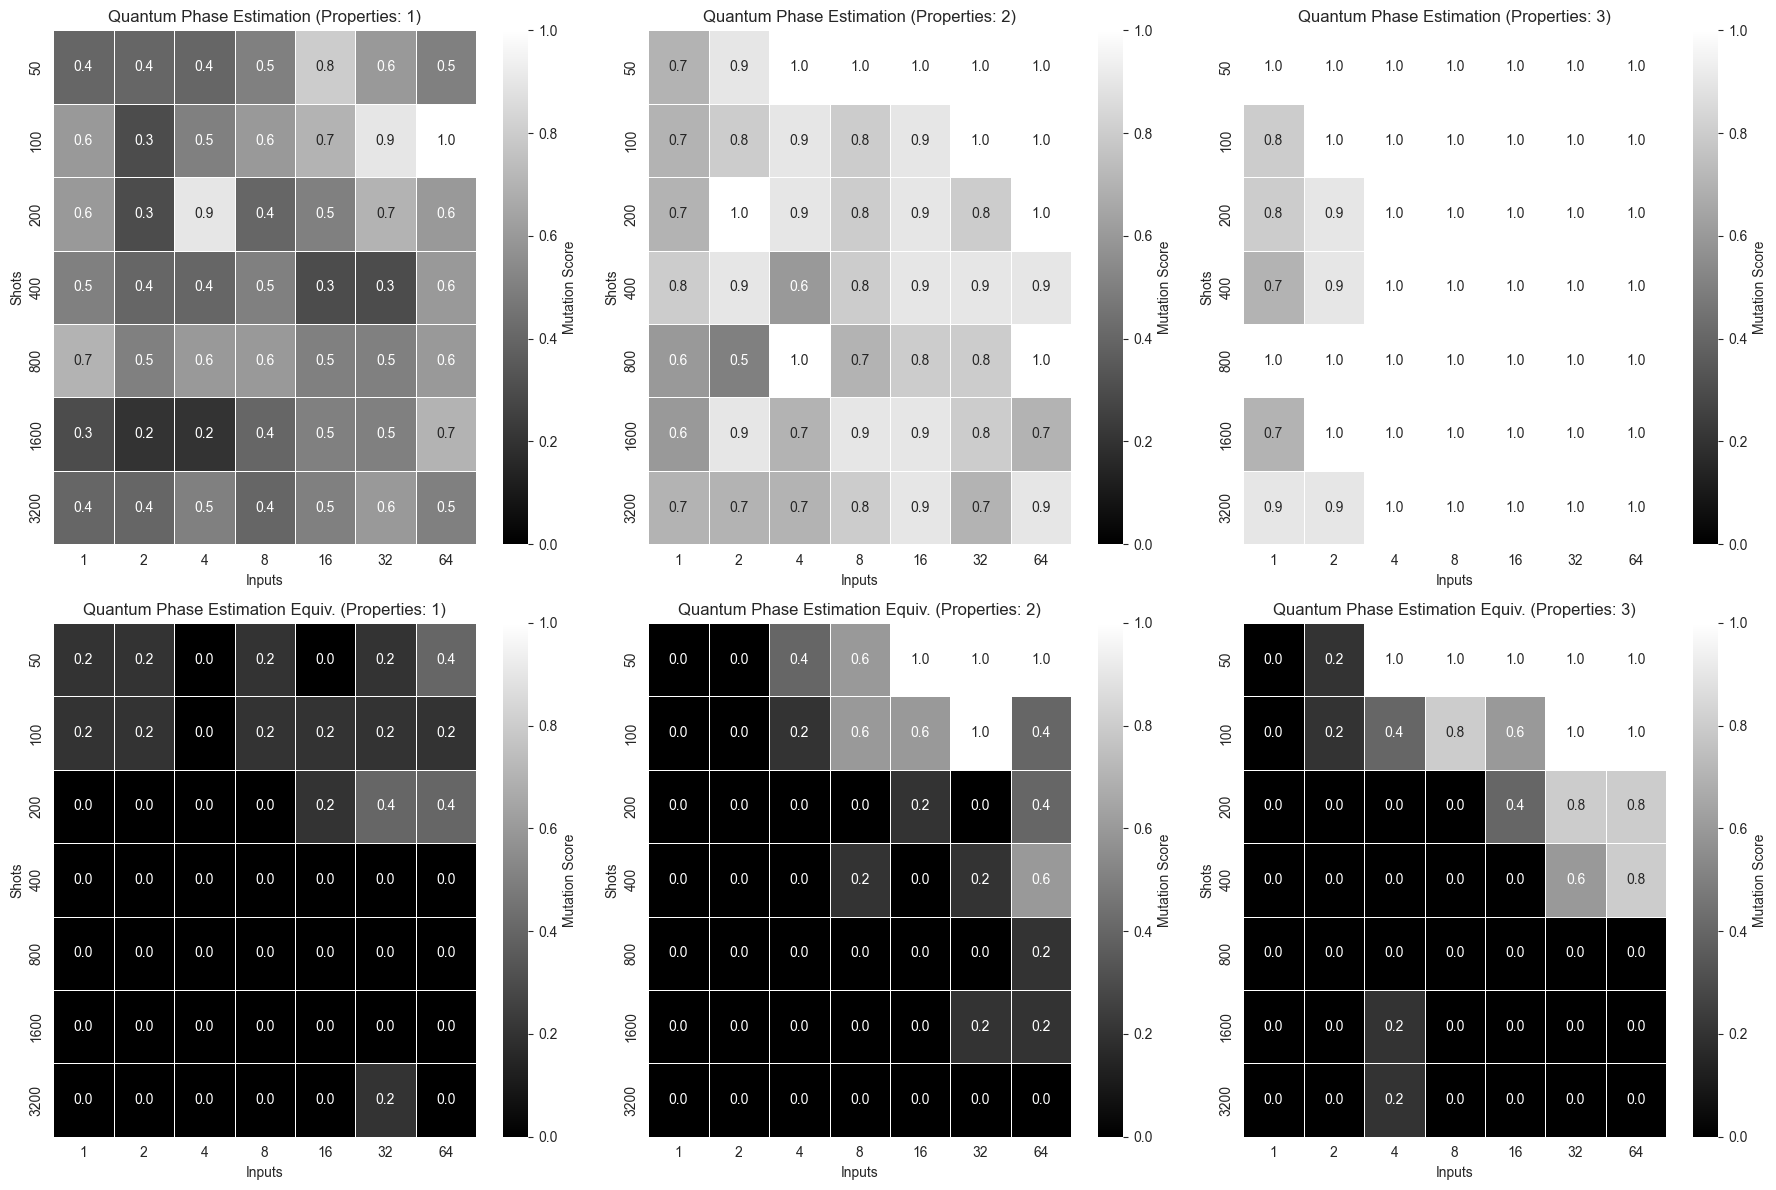

In [64]:
plot_failures(qpe_df, "Quantum Phase Estimation")

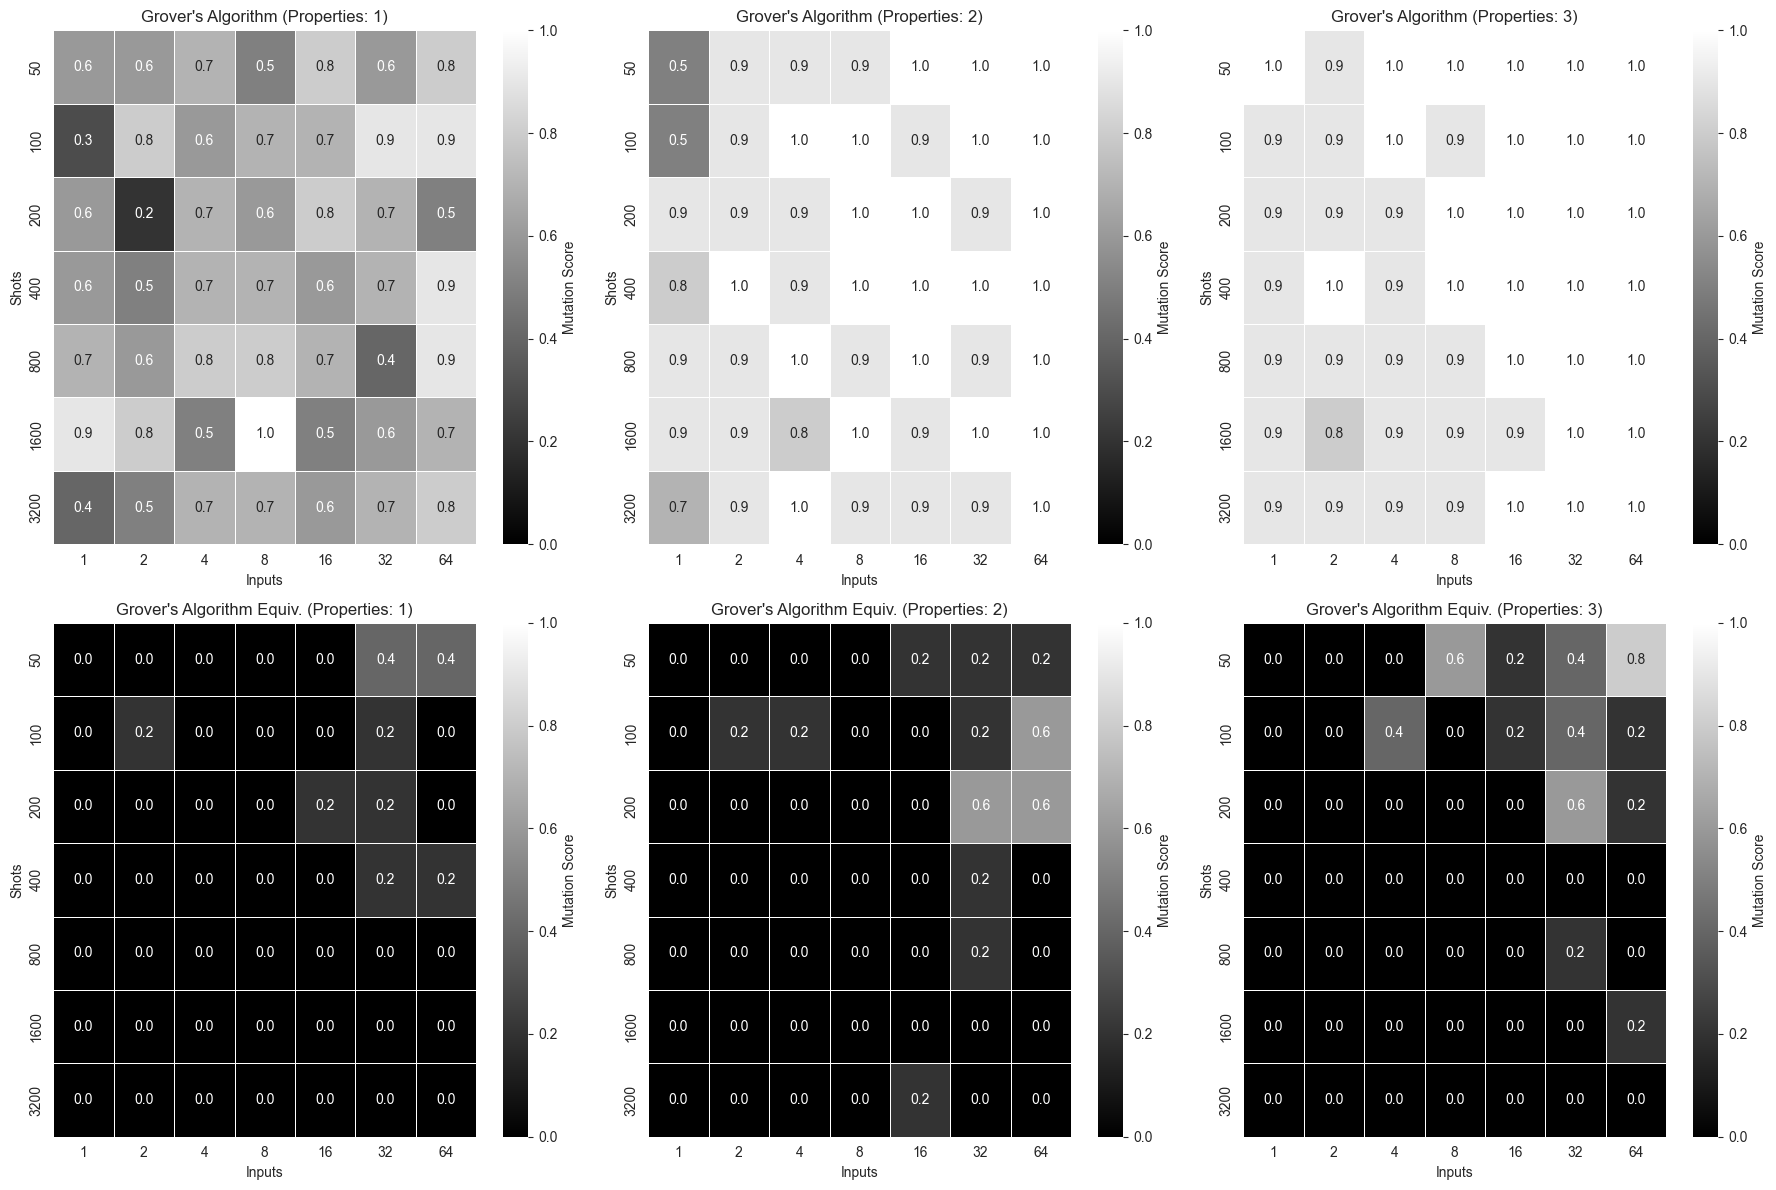

In [65]:
plot_failures(grover_df, "Grover's Algorithm")

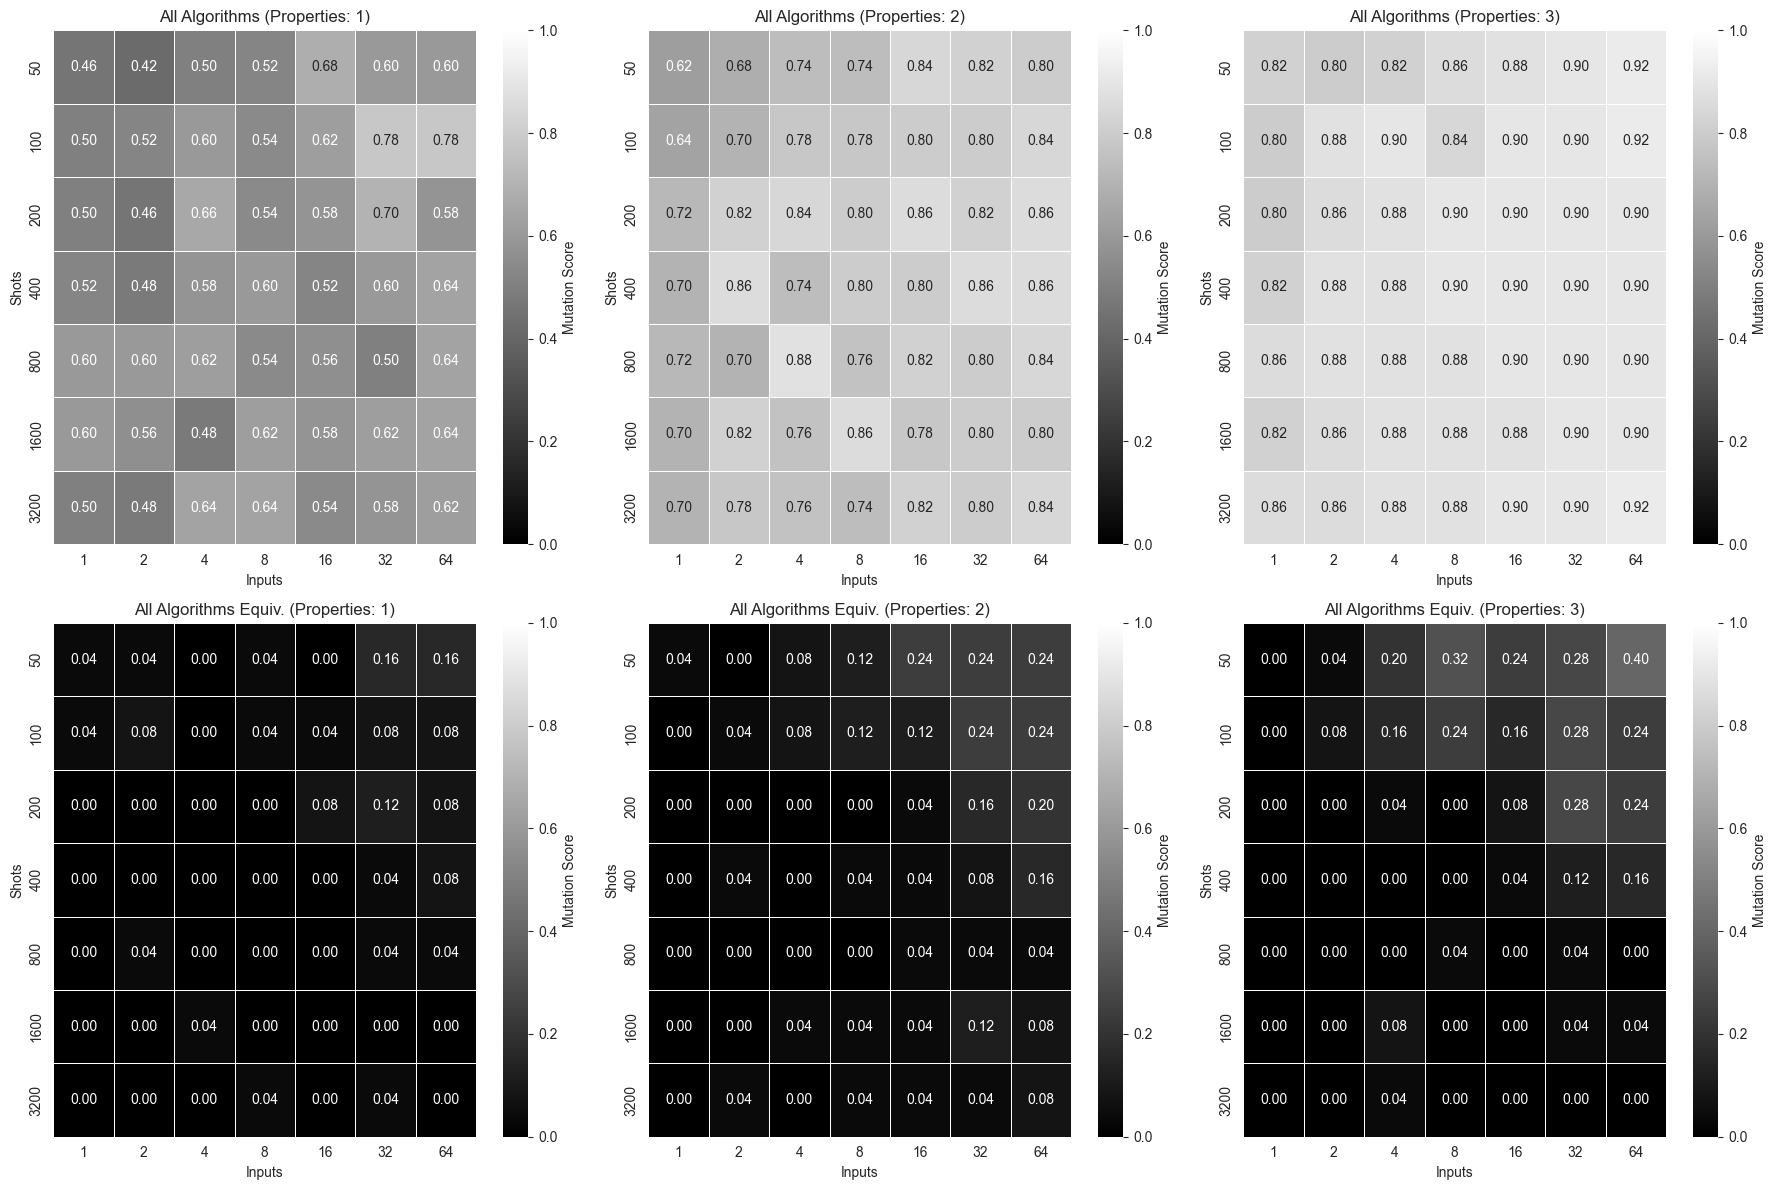

In [66]:
plot_failures(all_df, "All Algorithms", dp_format=".2f")

In [ ]:
 def plot_time_taken(df, algorithm_name):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # viridis or magma
    palette = sns.color_palette("viridis", as_cmap=True)

    sum_non_equiv_times = []
    # store the max sum time taken non equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        # get the largest value from the unstacked dataframe
        largest_value = failure_rate.max().max()
        sum_non_equiv_times.append(largest_value)
    max_time_non_equiv = max(sum_non_equiv_times)
        
    sum_equiv_times = []
    # store the max sum time taken equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        largest_value = failure_rate.max().max()
        sum_equiv_times.append(largest_value)
    max_time_equiv = max(sum_equiv_times)
        

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(failure_rate, annot=True, cmap=palette, ax=axes[0, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_non_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(pass_rate, annot=True, cmap=palette, ax=axes[1, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')

    plt.tight_layout()
    plt.savefig(f"{algorithm_name.replace("")}_time_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_time_taken(qt_df, "Quantum Teleportation")

In [ ]:
plot_time_taken(dj_df, "Deutsch-Jozsa")

In [ ]:
plot_time_taken(qft_df, "Quantum Fourier Transform")

In [ ]:
plot_time_taken(qpe_df, "Quantum Phase Estimation")

In [ ]:
plot_time_taken(grover_df, "Grover's Algorithm")

In [ ]:
def read_merged_data_to_dataframe(algorithm_name, csv_filename):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{csv_filename}.csv"
    return pd.read_csv(filename)

qs_qt_df = read_merged_data_to_dataframe("quantum_teleportation", "QTQS_in_out")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, feature_str):
    # Define configurations
    configs = [
        {'measurements': 1600, 'inputs': 32},
        {'measurements': 3200, 'inputs': 32},
        {'measurements': 1600, 'inputs': 64},
        {'measurements': 3200, 'inputs': 64}
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)
    
    for idx, config in enumerate(configs):
        ax = axes[idx // 2, idx % 2]
        
        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == config['measurements']) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]
        
        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == config['measurements']) &
            (qt_df['Number of Inputs'] == config['inputs'])
        ]
                
        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').sum()
        
        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').sum()
        
        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').sum()
        
        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').sum()
        
        # Prepare data for plotting
        algorithms = ["Non-Equivalent", "Equivalent"]
        qiskit_results = np.array([qt_non_equiv_failures, qt_equiv_failures])
        qs_results = np.array([qs_non_equiv_failures, qs_equiv_failures])
        
        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.35
        
        rects1 = ax.bar(x - width/2, qiskit_results, width, label='Qiskit', alpha=0.8)
        rects2 = ax.bar(x + width/2, qs_results, width, label='Q#', alpha=0.8)
        
        ax.set_ylabel('Property Failures')
        ax.set_title(f'Measurements: {config["measurements"]}, Inputs: {config["inputs"]}')
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)
        ax.legend()
        
        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
        
        ax.set_ylim(0, max(qiskit_results.max(), qs_results.max()) * 1.2)
        ax.grid(False)
    
    plt.tight_layout()
    # plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, "Result")

In [ ]:
# plot the result for quantum teleportation, comparing QS and no QS
def plot_quantitative_analysis_comparison(feature_str):
    # get the number of failures for qs_qt_df
    qs_qt_df_non_equivalent = qs_qt_df[qs_qt_df['Mutant Name'].str.contains('_m')]
    qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').sum()
    
    qs_qt_df_equivalent = qs_qt_df[qs_qt_df['Mutant Name'].str.contains('_em')]
    qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').sum()
    
    # get the number of failures for qt_df
    qt_df_non_equivalent = qt_df[qt_df['Mutant Name'].str.contains('_m')]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['Number of Measurements'] == 2000]
    qt_df_non_equivalent = qt_df_non_equivalent[qt_df_non_equivalent['Number of Inputs'] == 25]
    qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').sum() 
    
    qt_df_equivalent = qt_df[qt_df['Mutant Name'].str.contains('_em')]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['Number of Measurements'] == 2000]
    qt_df_equivalent = qt_df_equivalent[qt_df_equivalent['Number of Inputs'] == 25]
    qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').sum() 

    algorithms = ["Quantum Teleportation"]
    
    algorithms_results_qiskit_non_equiv = np.array([qt_non_equiv_failures])
    algorithms_results_qs_non_equiv = np.array([qs_non_equiv_failures])
    algorithms_results_qiskit_equiv = np.array([qt_equiv_failures])
    algorithms_results_qs_equiv = np.array([qs_equiv_failures])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 10))
    width = 0.25
    
    # Define x-positions for the bars
    x = np.arange(len(algorithms))
    
    # Create the bars for non-equivalent mutants
    rects1 = ax1.bar(x - width/2, algorithms_results_qiskit_non_equiv, width, label='Qiskit', alpha=0.8)
    rects2 = ax1.bar(x + width/2, algorithms_results_qs_non_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for non-equivalent mutants
    ax1.set_ylabel('Property Failures')
    ax1.set_title('Comparison of Q# and Qiskit mutation testing\nNon-equivalent mutants')
    ax1.set_xticks(x)
    ax1.set_xticklabels(algorithms)
    ax1.legend()
    
    # Add value labels on the bars
    ax1.bar_label(rects1, padding=3)
    ax1.bar_label(rects2, padding=3)
    
    ax1.set_ylim(0, 10) 
    ax1.grid(False)
    
    # Create the bars for equivalent mutants
    rects3 = ax2.bar(x - width/2, algorithms_results_qiskit_equiv, width, label='Qiskit', alpha=0.8)
    rects4 = ax2.bar(x + width/2, algorithms_results_qs_equiv, width, label='Q#', alpha=0.8)
    
    # Customize the plot for equivalent mutants
    ax2.set_ylabel('Property Failures')
    ax2.set_xlabel('Algorithms')
    ax2.set_title('Comparison of Q# and Qiskit mutation testing\nEquivalent mutants')
    ax2.set_xticks(x)
    ax2.set_xticklabels(algorithms)
    ax2.legend()
    
    # Add value labels on the bars
    ax2.bar_label(rects3, padding=3)
    ax2.bar_label(rects4, padding=3)
    
    ax2.set_ylim(0, 5) 
    ax2.grid(False)
    
    # Adjust layout and display
    fig.tight_layout()
    plt.show()

# Call the function
plot_quantitative_analysis_comparison("Result")

In [36]:
def split_and_group_dfs(dfs):
    grp_and_split_dfs = []
    for algorithm_df in dfs:
            df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
            df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]
    
            failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
            pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
            
            grp_and_split_dfs.append((failure_rate, pass_rate))
    return grp_and_split_dfs

In [37]:
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]    
dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
split_grouped_dfs = split_and_group_dfs(dfs)

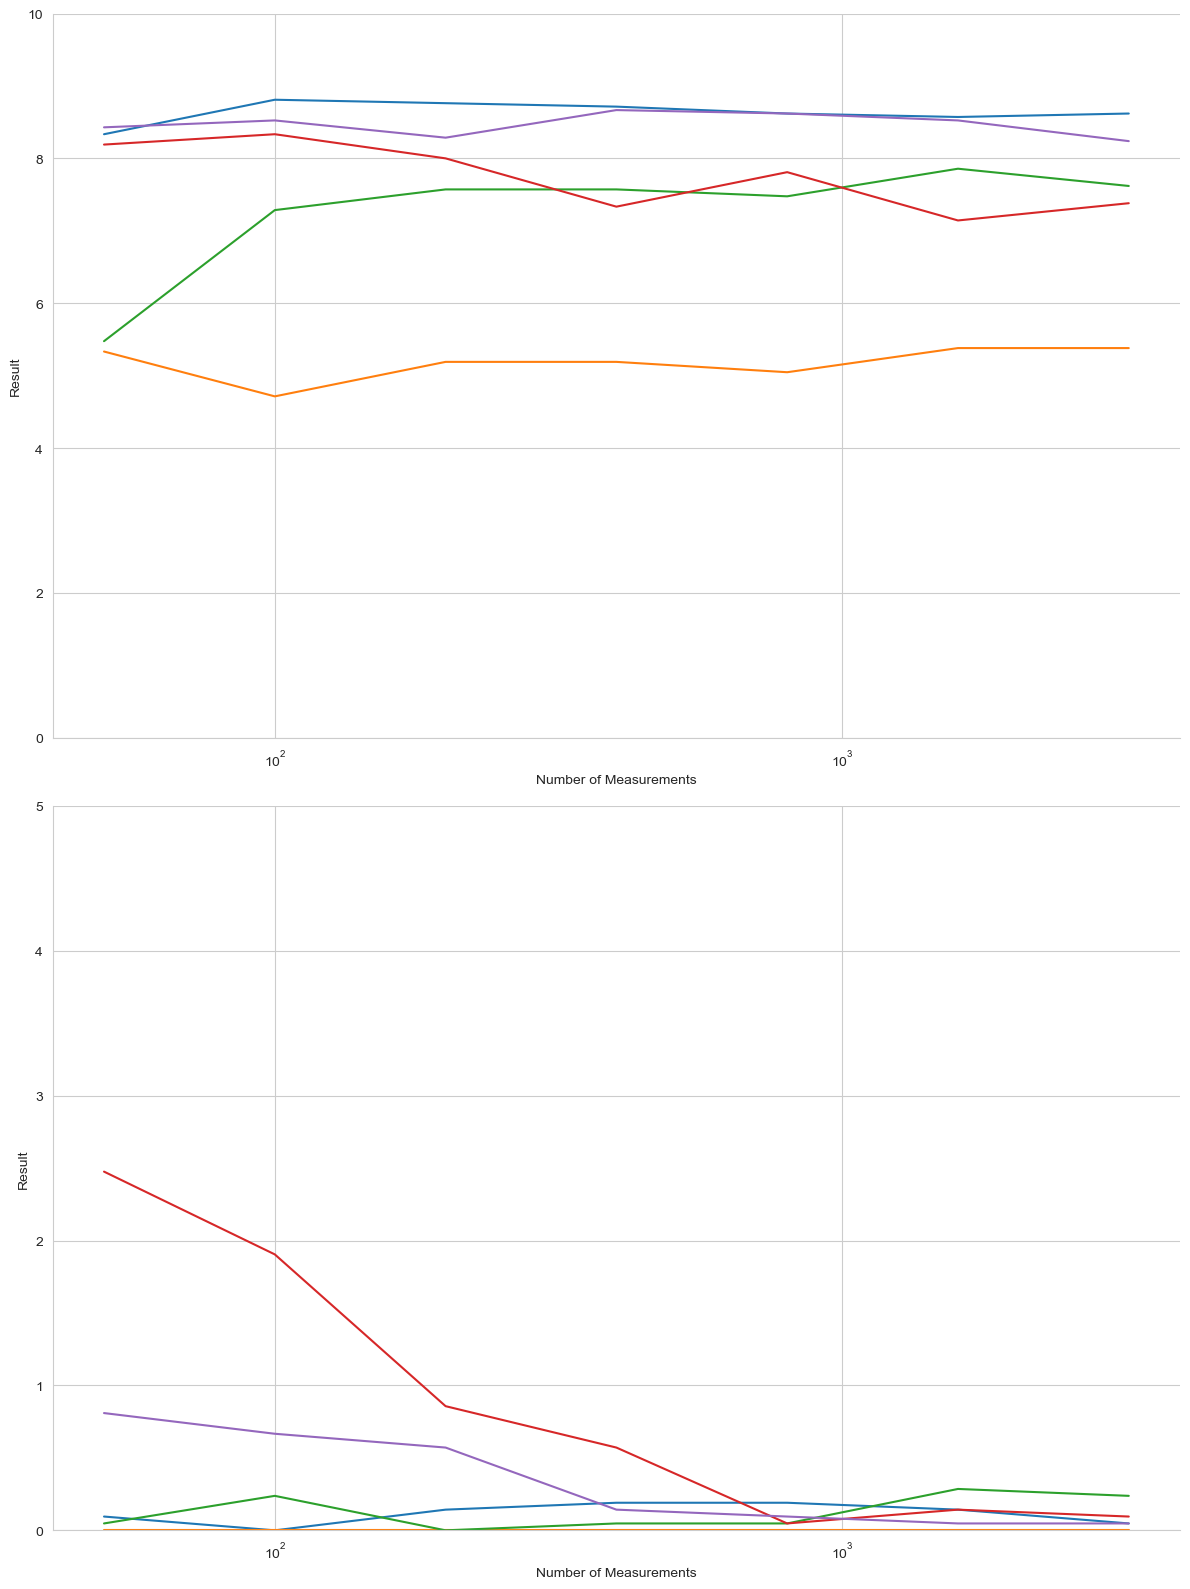

In [38]:
def plot_failures(dfs, algorithm_names, feature_str, log_scale=False):
    # Create a figure with 2 rows and 3 columns
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    ax1.set_ylim(0, 10)
    ax2.set_ylim(0, 5)
        
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')

    for df_non_equivalent, df_equivalent in dfs:
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index()
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result")
        
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index()
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result")

    sns.despine()
    plt.tight_layout()
    # plt.savefig(f"{algorithm_name}_failures_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()
    
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]    
dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
plot_failures(split_grouped_dfs, dfs_names, "Number of Measurements", log_scale=True)

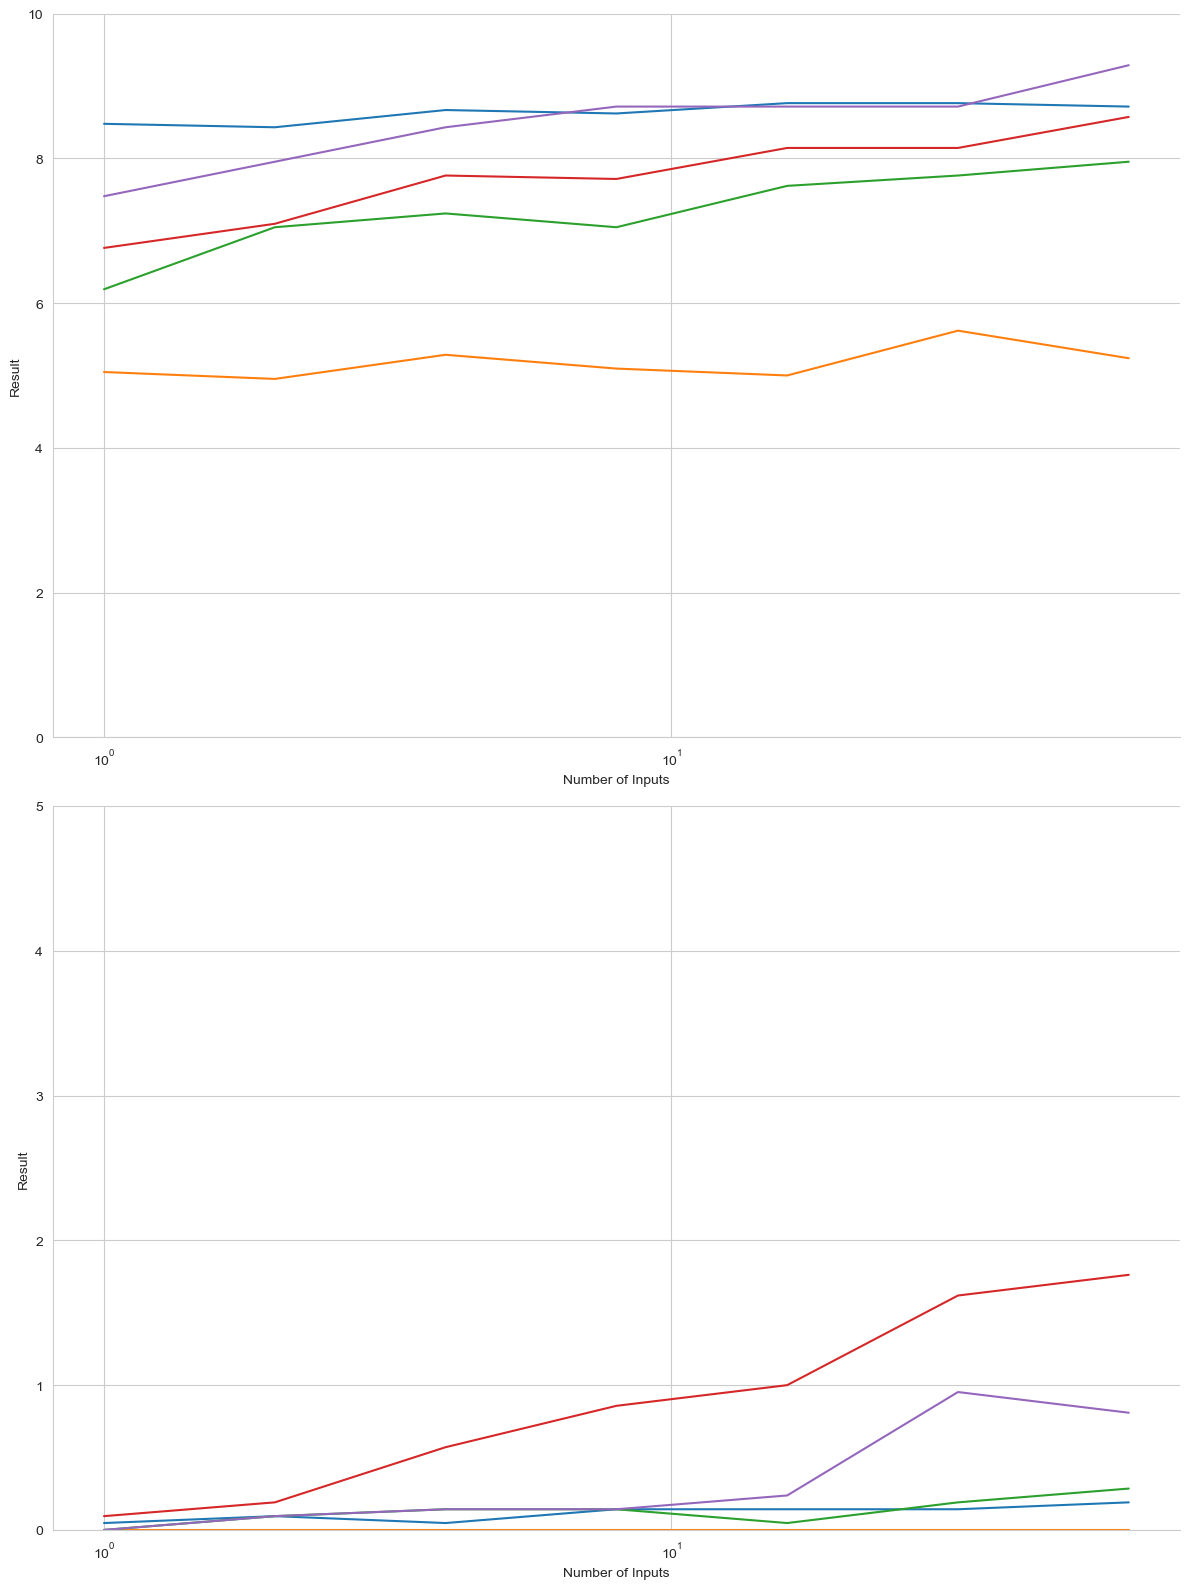

In [39]:
plot_failures(split_grouped_dfs, dfs_names, "Number of Inputs", log_scale=True)

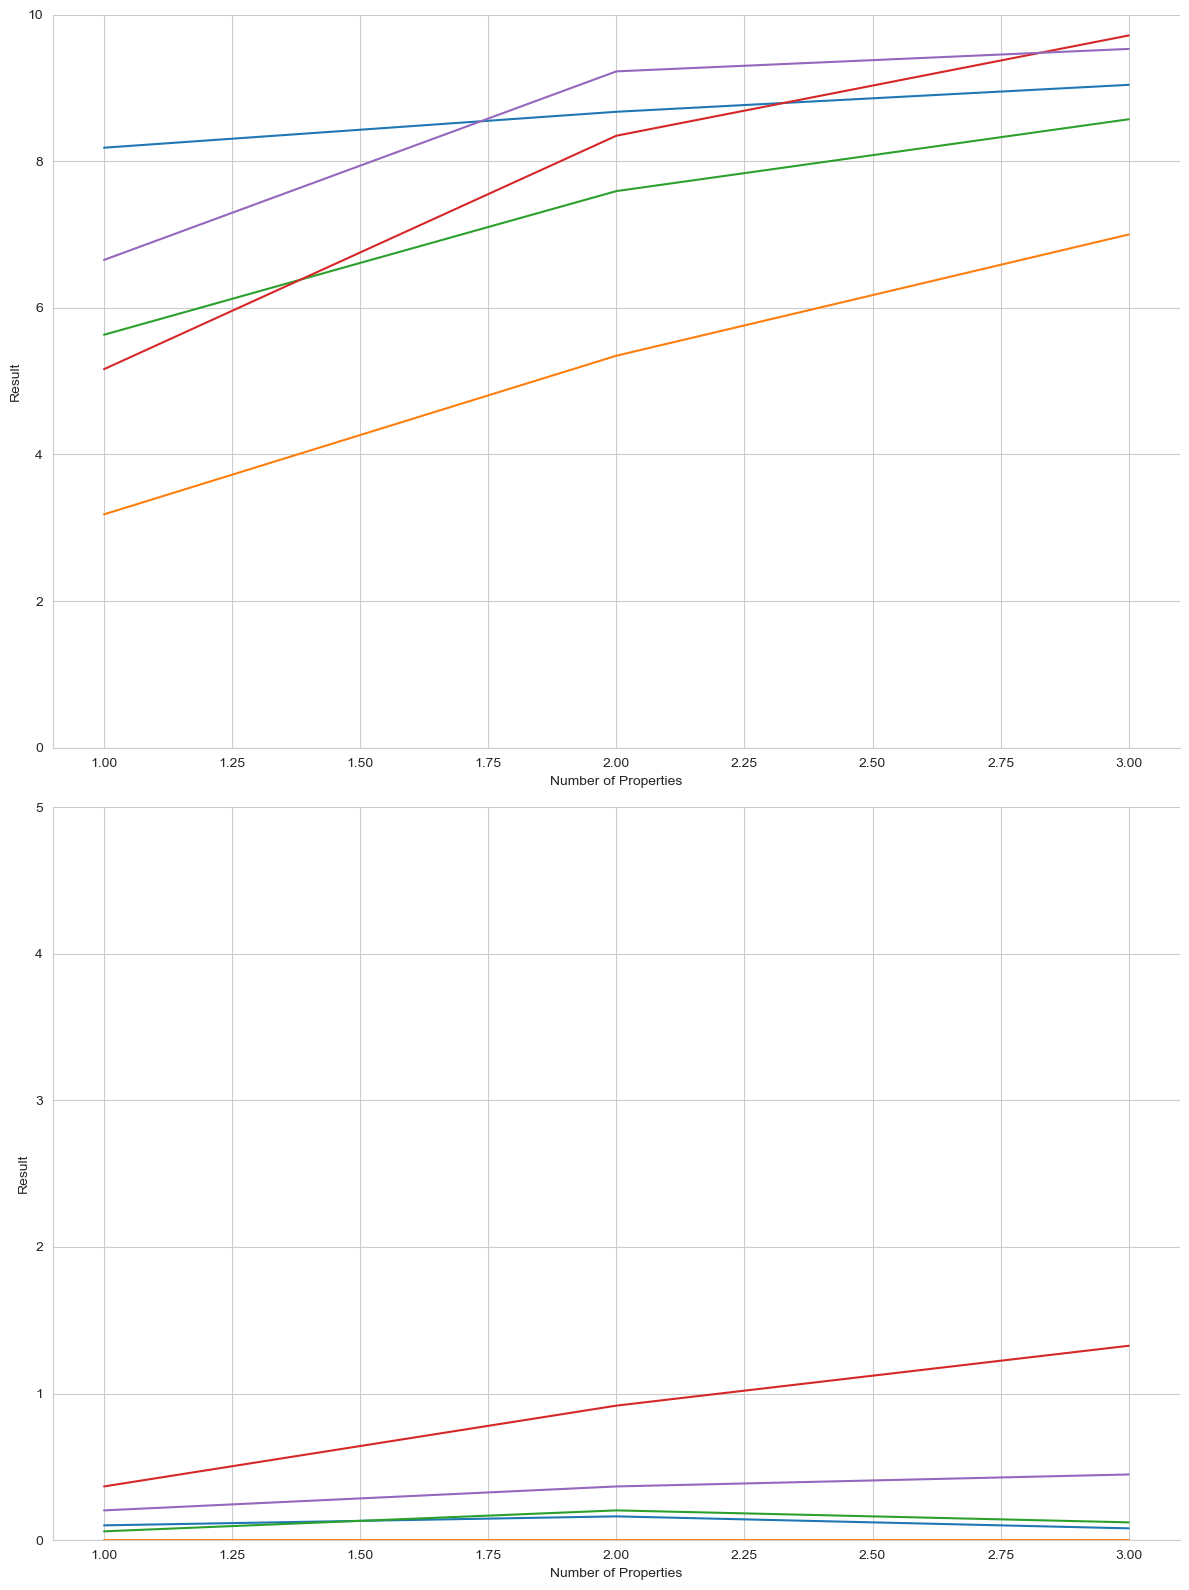

In [40]:
plot_failures(split_grouped_dfs, dfs_names, "Number of Properties", log_scale=False)

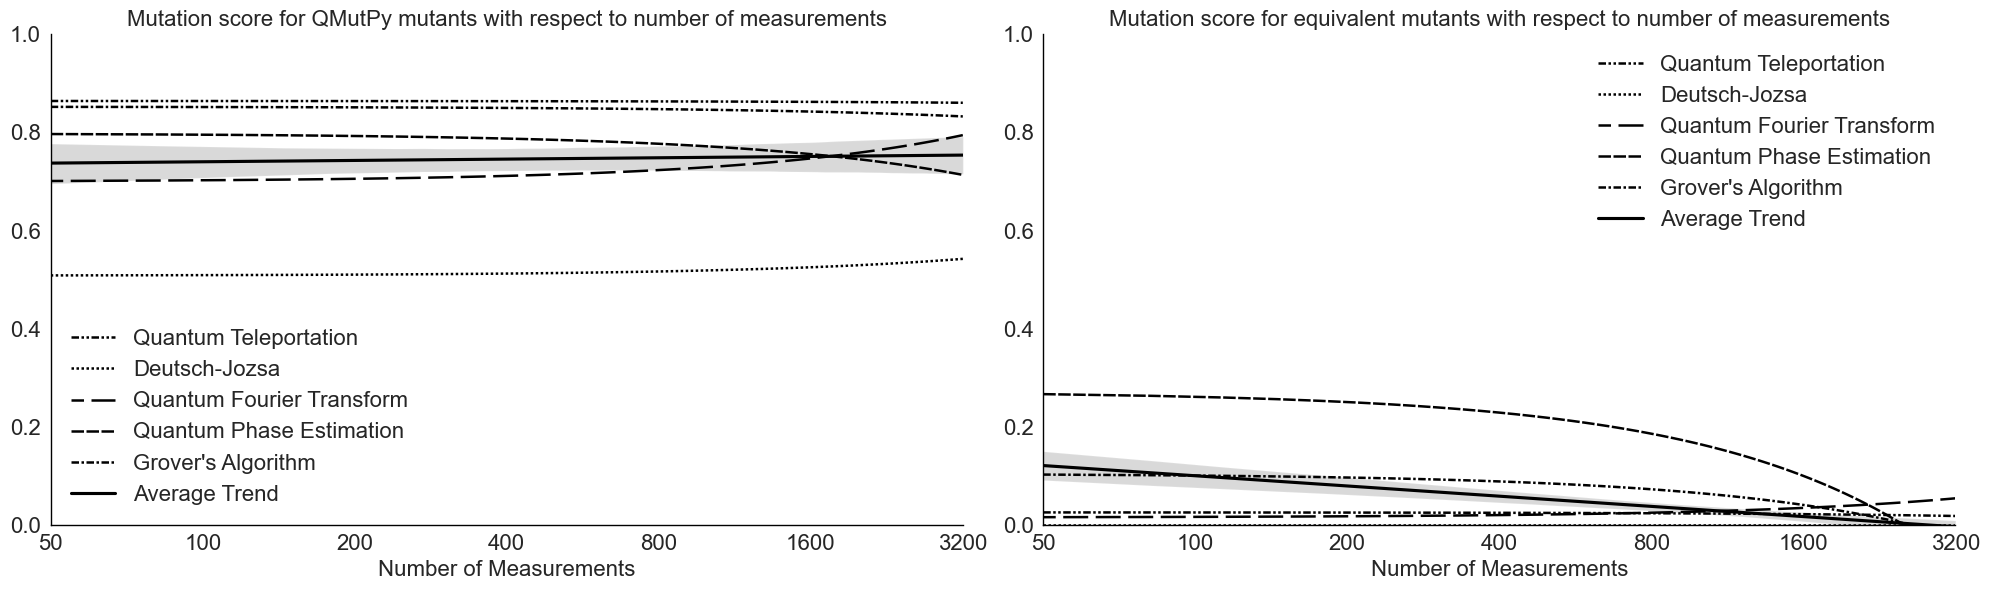

In [48]:
import matplotlib

def plot_failures(dfs, dfs_names, feature_str, log_scale=False, trendline=True):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (0, (3, 1, 1, 1, 1, 1)),       # solid line
        (0, (1, 1)),             # dashed line
        (5, (10, 3)),      # dash-dot line
        (0, (5, 1)),             # dotted line
        (0, (3, 1, 1, 1))      # dash-dot-dot line
    ]
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'Mutation score for QMutPy mutants with respect to {feature_str.lower()}')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Mutation score for equivalent mutants with respect to {feature_str.lower()}')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]

        failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/10.0).reset_index(name='Result')
        # sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar="sd", err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=2, color="red", dashes="dotted")
        # sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        sns.regplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label=algorithm_name, ci=None, color="black", scatter=False, line_kws={'linewidth': 1.8, 'linestyle': dash_styles[idx]})
        
        pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/5.0).reset_index(name='Result')
        # sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar="sd", err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=2, color="red", dashes="dotted")
        # sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        sns.regplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label=algorithm_name, ci=None, color="black", scatter=False, line_kws={'linewidth': 1.8, 'linestyle': dash_styles[idx]})
        idx += 1
    
    if trendline:
        all_df = pd.concat(dfs)
        all_df_non_equivalent = all_df[all_df['Mutant Name'].str.contains('_m')]
        all_df_equivalent = all_df[all_df['Mutant Name'].str.contains('_em')]
        
        failure_rate = all_df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/50.0).reset_index(name='Result')
        sns.regplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="black", logx=log_scale, ci=95)
        
        pass_rate = all_df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/25.0).reset_index(name='Result')
        sns.regplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="black", logx=log_scale, ci=95)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


plot_failures(dfs, dfs_names, "Number of Measurements", log_scale=True)

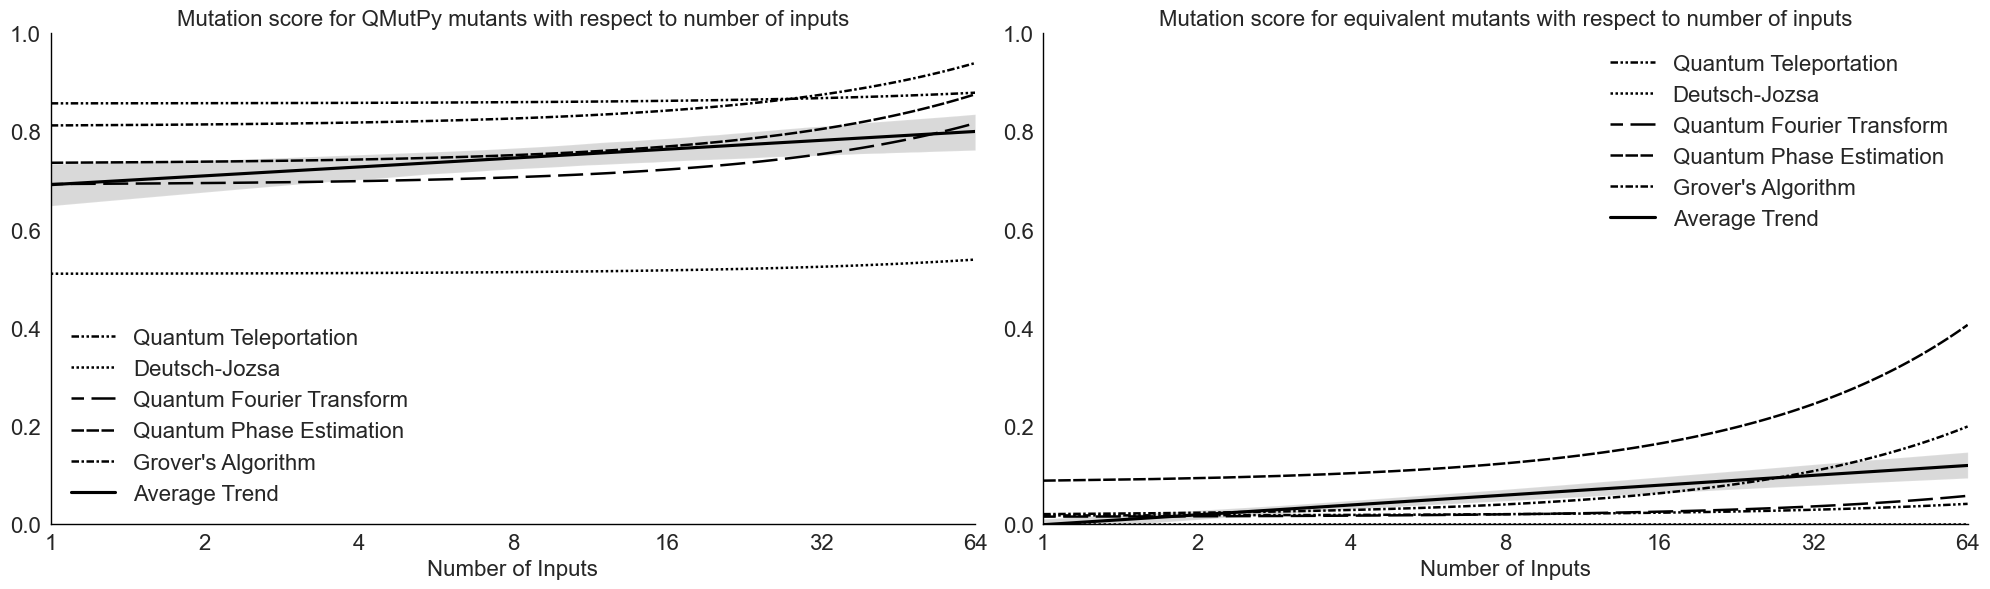

In [49]:
plot_failures(dfs, dfs_names, "Number of Inputs", log_scale=True)

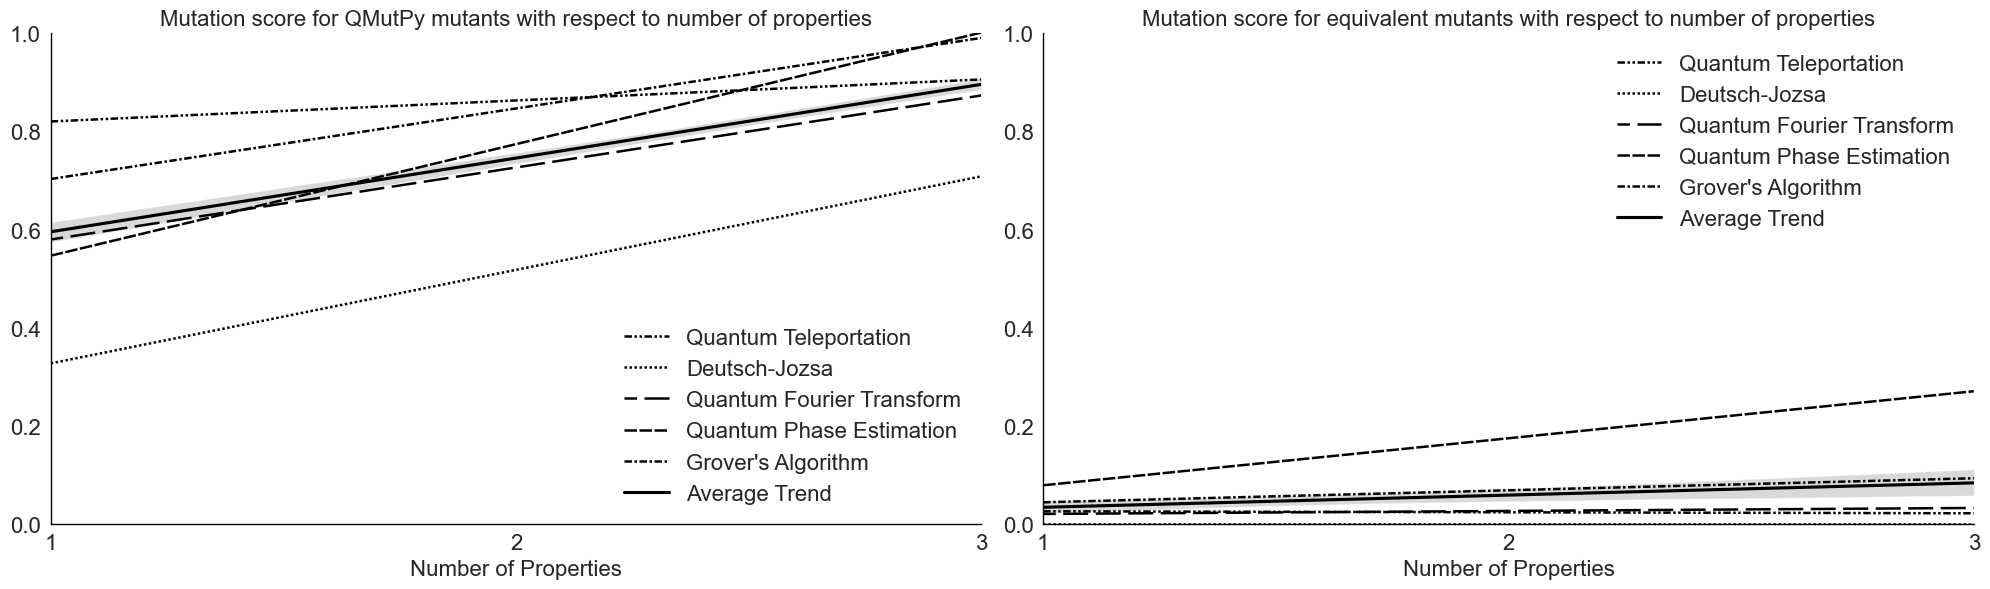

In [50]:
plot_failures(dfs, dfs_names, "Number of Properties", log_scale=False)

In [51]:
# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_standard_deviation(dfs, divide_multiplier=1, group_by="Number of Properties"):
    df_non_equivalent = dfs[dfs['Mutant Name'].str.contains('_m')]
    df_equivalent = dfs[dfs['Mutant Name'].str.contains('_em')]
    
    failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/(divide_multiplier*10.0)).reset_index(name='Result')
    if group_by is not None:
        standard_deviation_1 = failure_rate.groupby(group_by)['Result'].std()
    else:
        standard_deviation_1 = failure_rate['Result'].std()
    
    pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/(divide_multiplier*5.0)).reset_index(name='Result')
    if group_by is not None:
        standard_deviation_2 = pass_rate.groupby(group_by)['Result'].std()
    else:
        standard_deviation_2 = pass_rate['Result'].std()
        
    return standard_deviation_1, standard_deviation_2

get_standard_deviation(all_df, divide_multiplier=5, group_by=None)

(0.1392543745162708, 0.08325320908103519)

In [52]:
get_standard_deviation(qt_df, divide_multiplier=1, group_by="Number of Properties")

(Number of Properties
 1    0.072668
 2    0.055482
 3    0.019991
 Name: Result, dtype: float64,
 Number of Properties
 1    0.061168
 2    0.074688
 3    0.055328
 Name: Result, dtype: float64)

In [53]:
# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_median(dfs, divide_multiplier=1, group_by="Number of Properties"):
    df_non_equivalent = dfs[dfs['Mutant Name'].str.contains('_m')]
    df_equivalent = dfs[dfs['Mutant Name'].str.contains('_em')]
    
    failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/(divide_multiplier*10.0)).reset_index(name='Result')
    if group_by is not None:
        standard_deviation_1 = failure_rate.groupby(group_by)['Result'].median()
    else:
        standard_deviation_1 = failure_rate['Result'].median()
    
    pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/(divide_multiplier*5.0)).reset_index(name='Result')
    if group_by is not None:
        standard_deviation_2 = pass_rate.groupby(group_by)['Result'].median()
    else:
        standard_deviation_2 = pass_rate['Result'].median()
        
    return standard_deviation_1, standard_deviation_2

get_median(all_df, divide_multiplier=5, group_by=None)

(0.8, 0.04)

In [54]:
def get_pearson_correlation_coefficient(dfs, divide_multiplier=1, group_by="Number of Properties"):
    df_non_equivalent = dfs[dfs['Mutant Name'].str.contains('_m')]
    df_equivalent = dfs[dfs['Mutant Name'].str.contains('_em')]
    
    failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/(divide_multiplier*10.0)).reset_index(name='Result')
    print(failure_rate)
    r1 = scipy.stats.pearsonr(failure_rate[group_by], failure_rate["Result"], alternative='two-sided', method=None)
    
    pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/(divide_multiplier*5.0)).reset_index(name='Result')
    print(pass_rate)
    r2 = scipy.stats.pearsonr(pass_rate[group_by], pass_rate["Result"], alternative='two-sided', method=None)
        
    return r1, r2

get_pearson_correlation_coefficient(all_df, divide_multiplier=5, group_by="Number of Measurements")

     Number of Measurements  Number of Inputs  Number of Properties  Result
0                        50                 1                     1    0.46
1                        50                 1                     2    0.62
2                        50                 1                     3    0.82
3                        50                 2                     1    0.42
4                        50                 2                     2    0.68
..                      ...               ...                   ...     ...
142                    3200                32                     2    0.80
143                    3200                32                     3    0.90
144                    3200                64                     1    0.62
145                    3200                64                     2    0.84
146                    3200                64                     3    0.92

[147 rows x 4 columns]
     Number of Measurements  Number of Inputs  Number of Propert

(PearsonRResult(statistic=0.010156177669285036, pvalue=0.9028284927625235),
 PearsonRResult(statistic=-0.35219983463683363, pvalue=1.2157026652572042e-05))

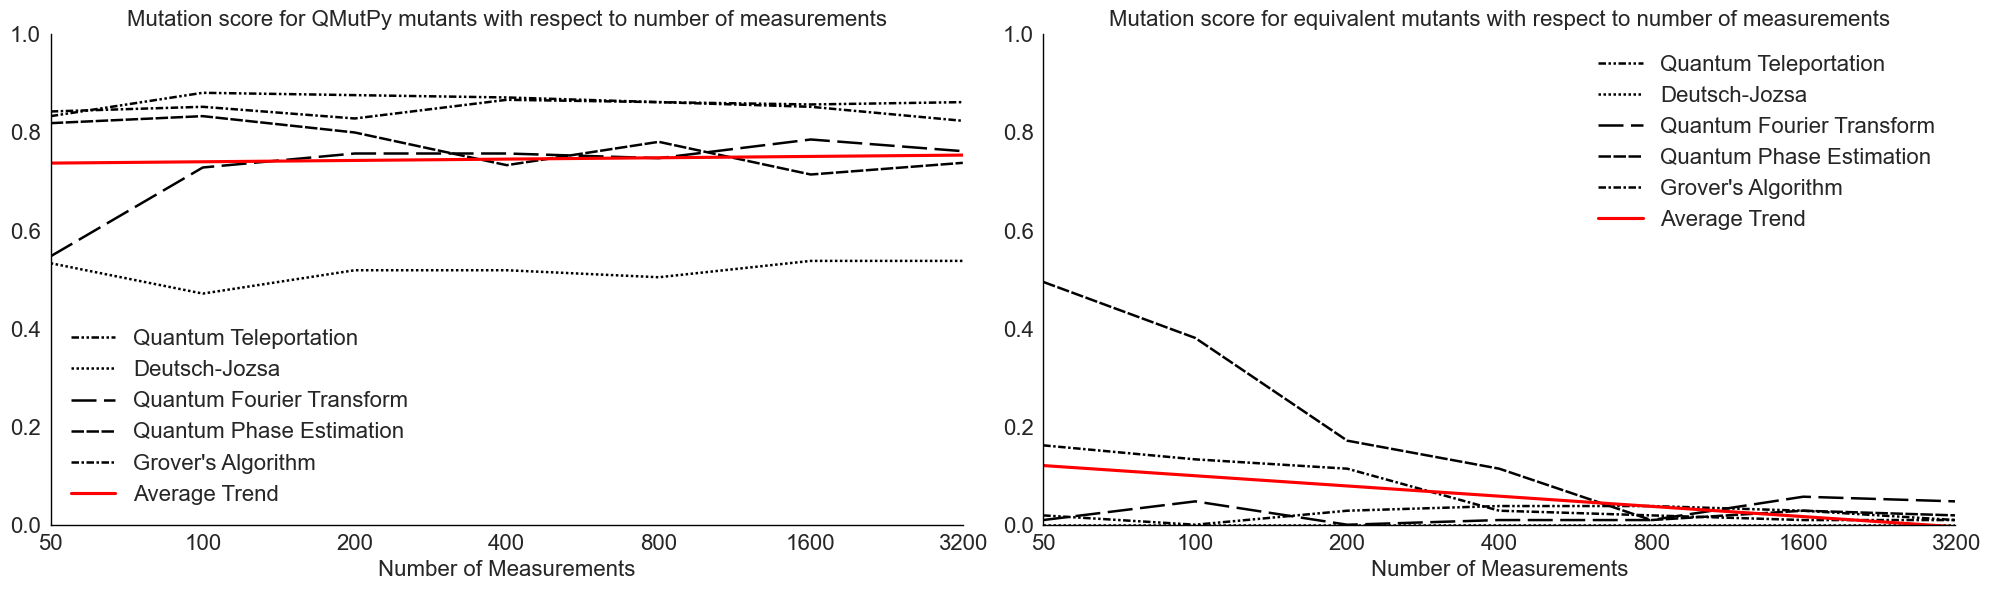

In [67]:
import matplotlib

def plot_failures(dfs, dfs_names, feature_str, log_scale=False, trendline=True):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (3, 1, 1, 1, 1, 1),       # solid line
        (1, 1),             # dashed line
        (10, 3),      # dash-dot line
        (5, 1),             # dotted line
        (3, 1, 1, 1)      # dash-dot-dot line
    ]
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'Mutation score for QMutPy mutants with respect to {feature_str.lower()}')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Mutation score for equivalent mutants with respect to {feature_str.lower()}')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]

        df_non_equivalent = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        failure_rate['Result'] = failure_rate['Result']/10.0
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        
        df_equivalent = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        pass_rate['Result'] = pass_rate['Result']/5.0
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        idx += 1
    
    if trendline:
        all_df = pd.concat(dfs)
        all_df_non_equivalent = all_df[all_df['Mutant Name'].str.contains('_m')]
        all_df_equivalent = all_df[all_df['Mutant Name'].str.contains('_em')]
        
        failure_rate = all_df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/50.0).reset_index(name='Result')
        sns.regplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="red", logx=log_scale, ci=None)
        
        pass_rate = all_df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/25.0).reset_index(name='Result')
        sns.regplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="red", logx=log_scale, ci=None)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


plot_failures(dfs, dfs_names, "Number of Measurements", log_scale=True)

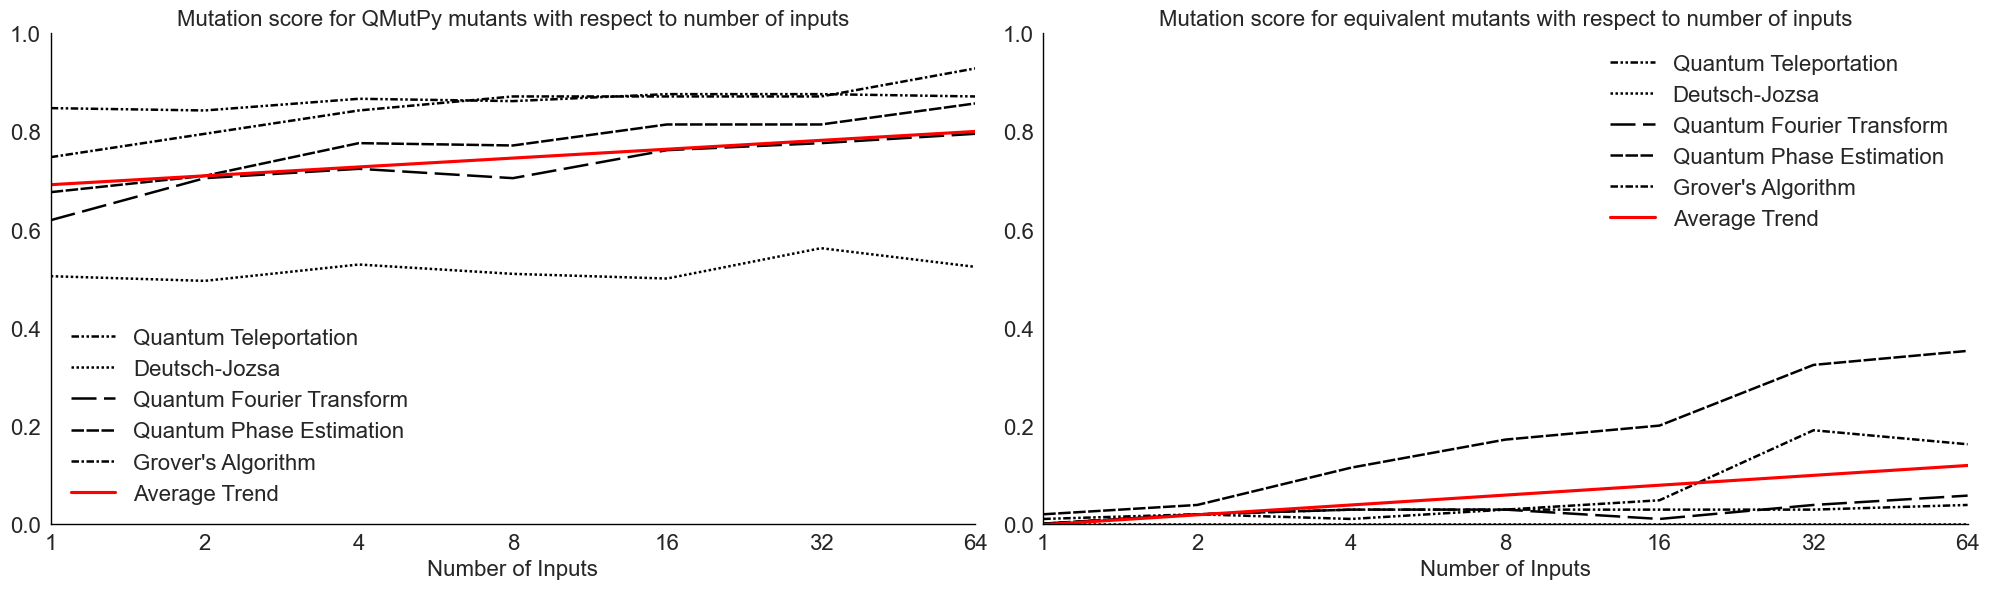

In [68]:
plot_failures(dfs, dfs_names, "Number of Inputs", log_scale=True)

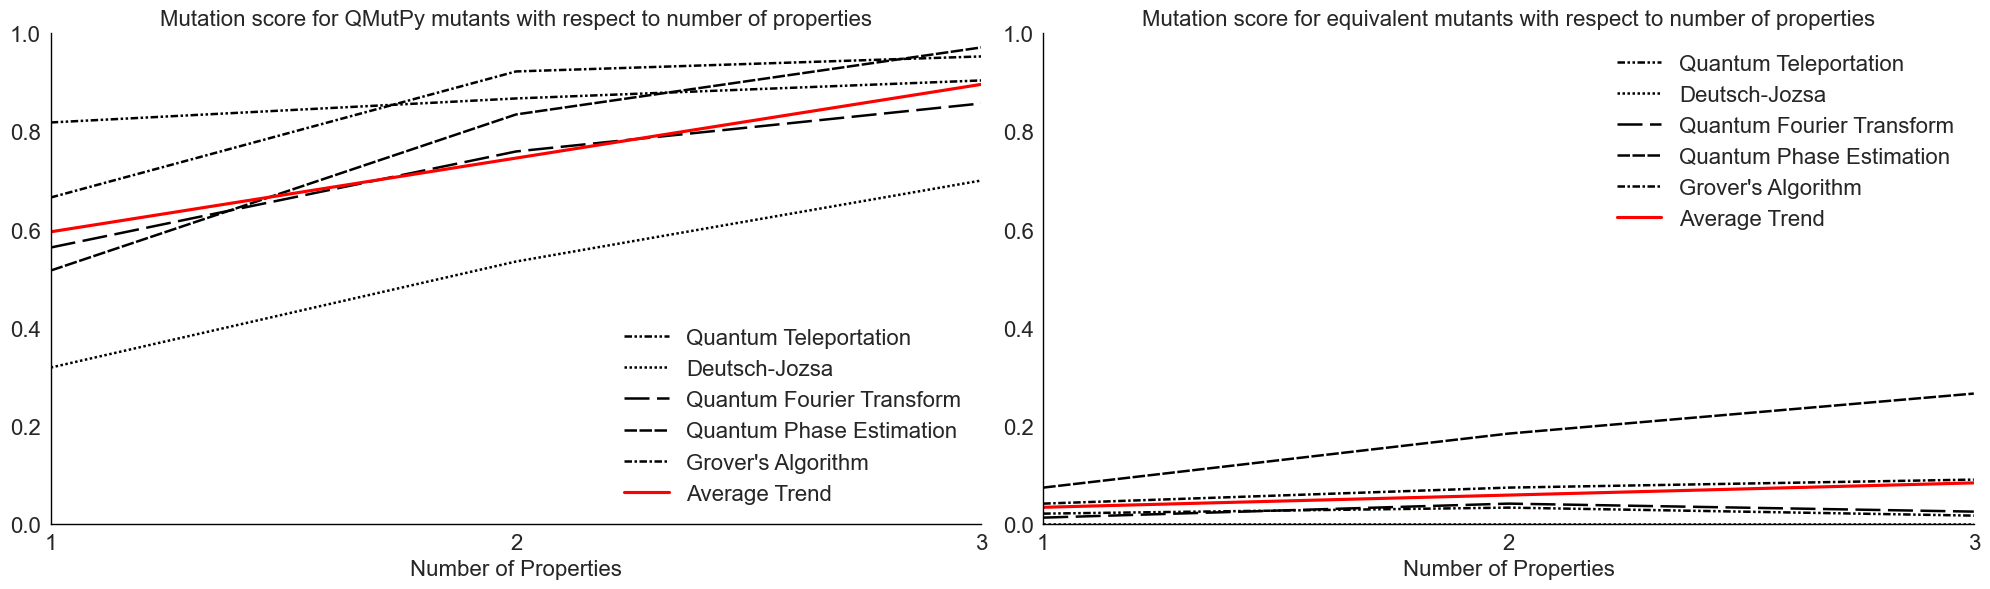

In [69]:
plot_failures(dfs, dfs_names, "Number of Properties", log_scale=False)
